## CT5133 / CT5145 Deep Learning (/Online) 2022-2023

## Assignment 2

## James McDermott

* Student ID(s): 22224253,22223505
* Student name(s): Rutwik Borole,Gaurav Bhosale

**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

In this assignment the goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with `### YOUR CODE HERE` markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [ ]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [ ]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

In [ ]:
img_array = np.array(images)

In [ ]:
img_array.shape

(1238, 268, 182, 3)

In [ ]:
img_array.max(), img_array.min()

(255.0, 0.0)

In [ ]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [ ]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [ ]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [ ]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [ ]:
df4.shape # 1254 rows matches the image data shape above

(1238, 6)

In [ ]:
df4['Year'].isnull().values.any()

False

In [ ]:
#df4['Year'] = df4['Year'].fillna(0)
df4.head()

,Imdb Link,Title,IMDB Score,Genre,Poster,Year
imdbId,,,,,,
1000771,http://www.imdb.com/title/tt1000771,Recount (2008),7.5,Drama|History,https://images-na.ssl-images-amazon.com/images...,2008.0
100148,http://www.imdb.com/title/tt100148,Midnight Ride (1990),5.2,Action|Horror|Thriller,https://images-na.ssl-images-amazon.com/images...,1990.0
1001540,http://www.imdb.com/title/tt1001540,Perestroika (2009),4.5,Drama,https://images-na.ssl-images-amazon.com/images...,2009.0
100200,http://www.imdb.com/title/tt100200,Mr. & Mrs. Bridge (1990),6.7,Drama,https://images-na.ssl-images-amazon.com/images...,1990.0
1002563,http://www.imdb.com/title/tt1002563,The Young Messiah (2016),5.5,Drama,https://images-na.ssl-images-amazon.com/images...,2016.0


In [ ]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]

In [ ]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.title("Chosen Image")
    plt.axis('off')

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

References:
1. https://keras.io/guides/sequential_model/
2. https://keras.io/api/applications/vgg/#vgg
3. https://keras.io/api/applications/vgg/#preprocess_input-function
4. https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

In [ ]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

n_movies = img_array.shape[0]
embedding_size = 20480
X = tf.zeros((n_movies, embedding_size))

# YOUR CODE HERE

#Using VGG16 pretrained model from keras 
base_model = VGG16(weights='imagenet',include_top=False , input_shape=(268, 182, 3))

#implementing layers with sequential model
model = tf.keras.Sequential()
model.add(base_model)
model.add(Flatten())

#model.summary()
processed_imgs = preprocess_input(img_array.copy())
features = model.predict(processed_imgs)

#reshaping embedding based on n_movies and embedding_size
X = features.reshape(n_movies, embedding_size)

assert len(X.shape) == 2 # X should be (n_movies, embedding_size)
assert X.shape[0] == n_movies

39/39 [==============================] - 142s 4s/step


In [ ]:
features.shape

(1238, 20480)

In [ ]:
#img_array.max(), img_array.min()

In [ ]:
#processed_imgs.max(), processed_imgs.min()

### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

References:
1. https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
2. https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
3. https://stackoverflow.com/questions/21661802/finding-the-distance-between-a-set-of-points-using-scipy-spatial-distance-cdist
4. https://www.geeksforgeeks.org/python-distance-between-collections-of-inputs/
5. https://sparkbyexamples.com/numpy/numpy-argsort-in-python/
6. https://stackoverflow.com/questions/17901218/numpy-argsort-what-is-it-doing

In [ ]:
from scipy.spatial.distance import cdist

def nearest(img, k):
    # Preprocess input image
    img = preprocess_input(np.array([img]))
    
    # Get embedding of input image
    emb = model.predict(img).reshape((1, -1))
    
    # Computing distance
    distances = cdist(emb, X, 'cosine')[0]
    
    # Get indices of k nearest neighbours (excluding the input image itself)
    idx = np.argsort(distances)[1:k+1]
    
    return idx

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 

References:
1. https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
2. https://python-course.eu/numerical-programming/creating-subplots-in-matplotlib.php

1/1 [==============================] - 0s 93ms/step


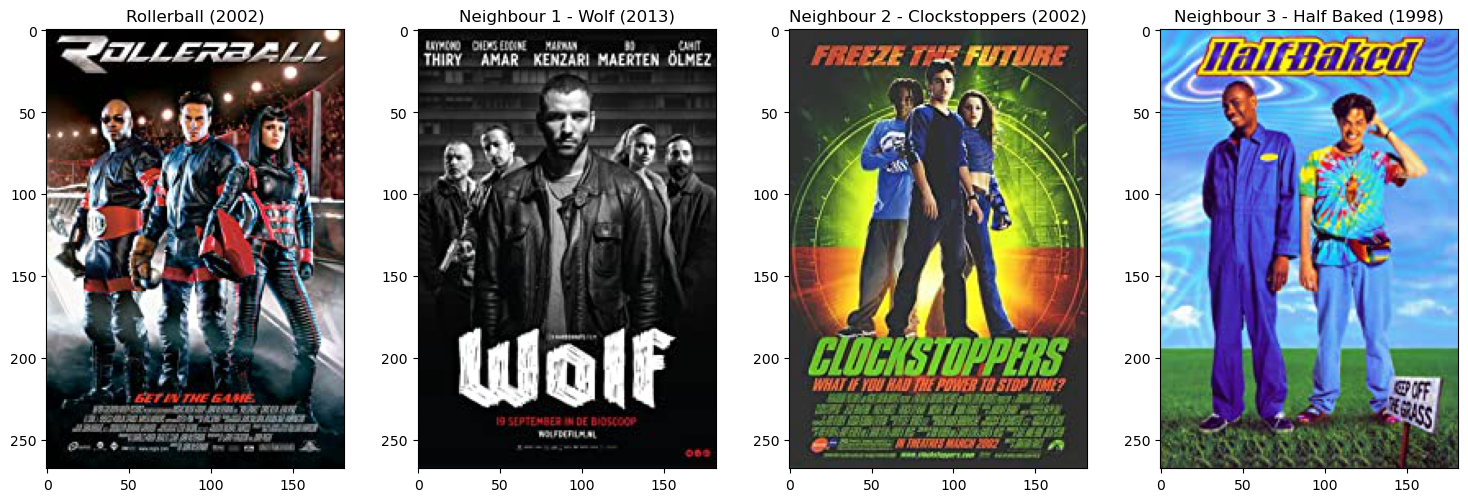

In [ ]:
Q_img = 246894
Q_arr = np.array(imread(Q_img))

# Find the nearest neighbours
neighbours = nearest(Q_arr, k=3)

#creating empty list for stroing the movie titles
titles =[]
Q_title = df4.loc[Q_img]["Title"]

# Show the query image and its title
fig, axs = plt.subplots(nrows=1, ncols=len(neighbours)+1, figsize=(15,5))
axs[0].imshow(imread(Q_img))
axs[0].set_title(df4.loc[Q_img]["Title"])
titles = [Q_title] + list(df4.iloc[neighbours]["Title"])

# Show the nearest neighbours and their titles
for i, idx in enumerate(neighbours):
    img = img_array[idx]/255
    movie_title = df4.iloc[idx]
    title = movie_title["Title"]
    axs[i+1].imshow(img)
    axs[i+1].set_title(f"Neighbour {i+1} - {title}")
    titles.append(title)
plt.tight_layout()
plt.show()



**If you see my chosen poster, you can see that there are 3 indiviuals stadning in the middle of the poster and also there is something written on the top and bottom of the poster like Movie Title/Cast Names/Director Name. And if we compare it to the 3 nearest posters we can see that all the three posters have people standing in th middle of the poster and even the title/names of the movie are found written on top and bottom. I also think that the few nearest posters have similar colors in them like Black, Red and Blue. So I would say that I agree to the choice of the nearest neighours and  the rankings of those neighbours given my chosen query poster.
The chosen movie poster's name is RollerBall which was released in 2002, whereas the neighbour 2(ClockStoppers) was relased in 2002 and neighbour 3(HalfBaked) was released in 1998, so we could say that they are from the same era, although the first nearest neighbour(Wolf) was released in 2013 which is more than a decade away from my chosen query poster.
The closest movies are chosen and ranked based only on how much space they take up in the embedding space. This may not always reflect how similar or different the movies are. Still, the fact that I think the closest neighbours look similar and are from the same time period (except neighbour 1) is a good sign that the embedding space is picking up on some important parts of the movie posters.**

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

References:
1. https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
2. https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918
3. https://www.freecodecamp.org/news/python-slicing-how-to-slice-an-array/
4. https://sparkbyexamples.com/numpy/numpy-split-array/
5. https://www.cantorsparadise.com/huber-loss-why-is-it-like-how-it-is-dcbe47936473
6. https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber'


In [ ]:

# Split the data manually into training and testing sets
#This calculates the index to split the data. The n_movies variable contains the number of movies in the dataset, 
#and 0.8 is the proportion of the data we want to use for training (the remaining 0.2 will be used for testing). 
#The int() function is used to round the result down to an integer value, which we use as the split index.

split = int(0.8 * n_movies)
X_train, y_train = X[:split], years[:split]
X_test, y_test = X[split:], years[split:]


In [ ]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

#defining the model
model = Sequential([
    Flatten(),  # input shape is (number of features,)
    Dense(128, activation='relu'),  # one dense layer with 128 units and ReLU activation
    Dense(1, activation='linear')  # output layer with a single unit and linear activation for regression
])
# Compile the model
model.compile(optimizer='adam', loss='Huber')

# Train the model
model.fit(X_train, y_train, epochs=80, batch_size=50)

Epoch 1/80
20/20 [==============================] - 1s 18ms/step - loss: 797.0799
Epoch 2/80
20/20 [==============================] - 0s 18ms/step - loss: 361.6625
Epoch 3/80
20/20 [==============================] - 0s 17ms/step - loss: 244.5541
Epoch 4/80
20/20 [==============================] - 0s 18ms/step - loss: 178.4640
Epoch 5/80
20/20 [==============================] - 0s 22ms/step - loss: 137.5419
Epoch 6/80
20/20 [==============================] - 0s 21ms/step - loss: 118.5323
Epoch 7/80
20/20 [==============================] - 0s 23ms/step - loss: 101.0154
Epoch 8/80
20/20 [==============================] - 0s 20ms/step - loss: 101.3450
Epoch 9/80
20/20 [==============================] - 0s 21ms/step - loss: 93.0059
Epoch 10/80
20/20 [==============================] - 0s 21ms/step - loss: 85.5637
Epoch 11/80
20/20 [==============================] - 0s 23ms/step - loss: 79.0874
Epoch 12/80
20/20 [==============================] - 0s 21ms/step - loss: 75.2925
Epoch 13/80
20/20

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)

8/8 [==============================] - 0s 8ms/step - loss: 256.0202
Test loss: 256.0201721191406


In [ ]:
# Predict the year of the query image
test_img = 246894
Q_emb = features[IDs.index(test_img)].reshape(1, -1)
predicted_year = model.predict(Q_emb)

# Extract the actual year of the movie
movie_year = df4.loc[test_img]
actual_year = movie_year['Year']

#Print the predicted year
print('Movie Title:', movie_year["Title"])
print('Predicted year:',  np.round(predicted_year))
print('Actual year:', actual_year)

1/1 [==============================] - 0s 60ms/step
Movie Title: Rollerball (2002)
Predicted year: [[1981.]]
Actual year: 2002.0


**The model is able to predict the year of a movie poster to some extent, with a test loss of 256.02. However, the predicted year for the test image (Rollerball) is quite far off from the actual year (1981 vs 2002).<br>
This could be due to a number of factors, such as insufficient data, lack of relevant features in the dataset, or limitations of the neural network model used.<br>
It is difficult to make conclusions about trends over time based on this single prediction, but it is worth noting that the predicted year is much earlier than the actual year.<br>
This could indicate that the model is biased towards more earlier years, or that there is a lack of representation for newer movies in the dataset.**

### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

The proposed improvements include three approaches: using pre-trained models to create embeddings, visualization, and fine-tuning. They are following

**Xception pre-trained model**

For the pre-trained model, Xception is chosen, which is based on depthwise separable convolution. This involves two steps: depthwise and pointwise convolution, which help to efficiently extract features from input tensors. Skip connections are also used in order to gradient flow and avoid vanishing gradients. The results show that the Xception model performs well, as demonstrated by recommending relevant action movie posters when given an action movie poster as input.

**Visualization**

In the visualization, we used t-SNE(t-Distributed Stochastic Neighbor Embedding) in order to reduce dimensinality of calculated embedding from higher dimension to 2D for the good visualization.Here each year embedding is represented by different color with the help of YlOrRd color map.

**Fine tuning model**

The Huber loss function is being used in the current task due to the presence of noisy and extreme data points. it is combination of both the Mean Squared Error(MSE) and Absolute Error(AE). it is less sensitive to outliers compared to the MSE loss alone. The presence of outliers and noise in the data can lead to an result training of the model and affect its performance, hence we use Huber loss fucntion is convient way to calculate loss.
In the finetuning model, we are added 3 hidden layer with 256, 128 and 64 unit. we added the more hidden layer in order to learn complex pattern from the input data. After every dense layer, we have added dropout layer in order to avoid overfitting of the model.After fine tuning model, it was observed that the predicted year of the movie was often in close proximity to the actual year of the movie in many cases.


References:
1. https://keras.io/api/applications/#usage-examples-for-image-classification-models
2. https://keras.io/guides/transfer_learning/
3. https://keras.io/api/layers/pooling_layers/max_pooling2d/
4. https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
5. https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568
6. https://keras.io/api/applications/xception/
7. https://medium.com/analytics-vidhya/visualising-embeddings-with-t-sne-b54bf6b635f

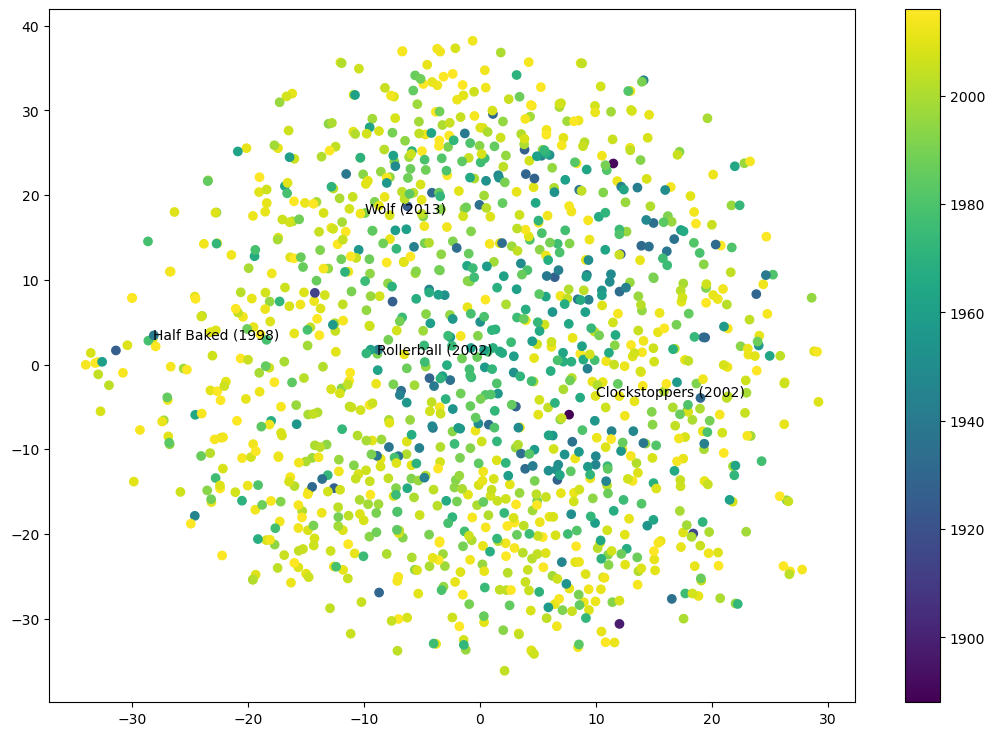

In [ ]:
### YOUR CODE HERE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce the dimensionality of the embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, metric="cosine",n_iter=1200)
X_embedded = tsne.fit_transform(X)

# Plot the embeddings

fig, ax = plt.subplots(figsize=(13,9))
scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=years, cmap='viridis')

# Add labels
for i, txt in enumerate(set(titles)):
    ax.annotate(txt, (X_embedded[i,0], X_embedded[i,1]))

#displaying the color legend
plt.colorbar(scatter)
#displaying the plot
plt.show()

In [ ]:

from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D
from tensorflow.keras.applications import Xception
from keras.applications.xception import preprocess_input

n_movies_1 = img_array.shape[0]
embedding_size_1 = 24576
X_new = tf.zeros((n_movies_1, embedding_size_1))

#using xception pretrained model from keras
base_model_1 = Xception(weights='imagenet',include_top=False , input_shape=(268, 182, 3))

#defining the model
model_1 = tf.keras.Sequential()
model_1.add(base_model_1)
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.summary()

#preprocessing the images
processed_imgs_1 = preprocess_input(img_array.copy())
features_1 = model_1.predict(processed_imgs_1)

#reshaping the features into n_movies1 and embedding_size_1 
X_new = features_1.reshape(n_movies_1, embedding_size_1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 9, 6, 2048)        20861480  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 3, 2048)       0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 24576)             0         
                                                                 
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
_________________________________________________________________
39/39 [==============================] - 72s 2s/step


In [ ]:
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding
def nearest_new(img, k):
    # Preprocess input image
    img = preprocess_input(np.array([img]))
    
    # Get embedding of input image
    emb = model_1.predict(img).reshape((1, -1))
    
    # Computing distance
    distances = cdist(emb, X_new, 'cosine')[0]
    
    # Get indices of k nearest neighbours (excluding the input image itself)
    idx = np.argsort(distances)[1:k+1]
    
    return idx

1/1 [==============================] - 0s 106ms/step


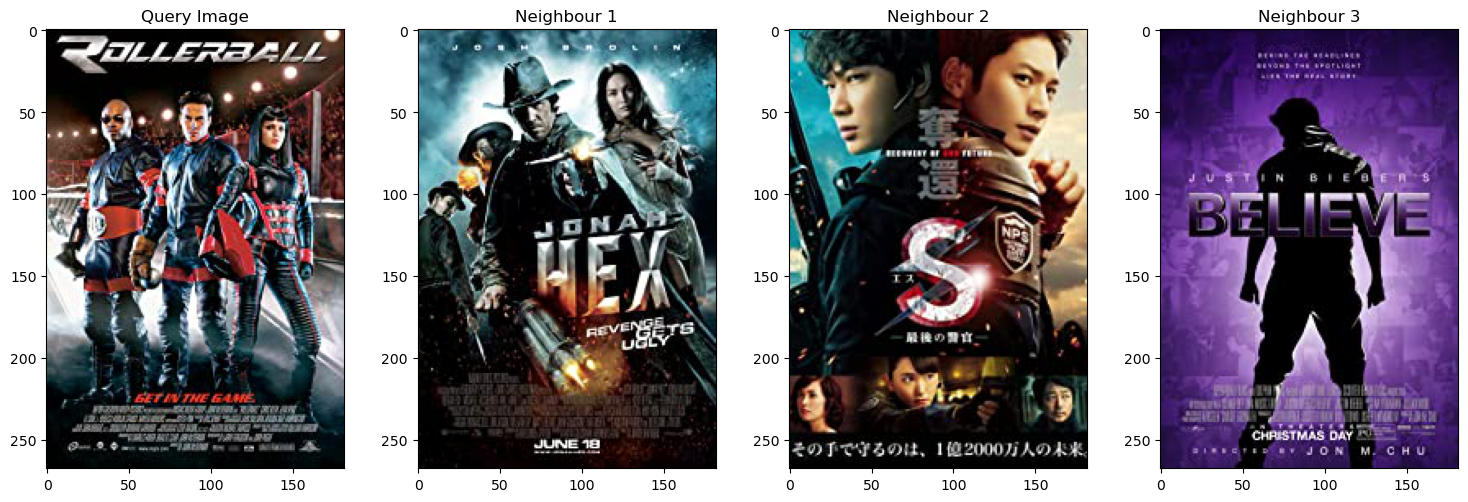

In [ ]:
Q_img = 246894
Q_arr = np.array(imread(Q_img))
# Find the nearest neighbours
neighbours_new = nearest_new(Q_arr, k=3)

# Show the nearest neighbours
fig, axs = plt.subplots(nrows=1, ncols=len(neighbours_new)+1, figsize=(15,5))
axs[0].imshow(imread(Q_img))
axs[0].set_title("Query Image")
for i, idx in enumerate(neighbours_new):
    img = img_array[idx]/255
    axs[i+1].imshow(img)
    axs[i+1].set_title(f"Neighbour {i+1}")
plt.tight_layout()
plt.show()

In [ ]:
#Finetuning the model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

#defining the model
model_2 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),  # hidden layer 1 with 256 units
    Dropout(0.4),  # dropout layer with a rate of 0.4 to reduce overfitting
    Dense(128, activation='relu'),  # hidden layer 2 with 128 units
    Dropout(0.4),  # dropout layer with a rate of 0.4
    Dense(64, activation='relu'),  # hidden layer 3 with 64 units
    Dropout(0.4),  # dropout layer with a rate of 0.4
    Dense(1, activation='linear')  # output layer with a single unit and linear activation for regression
])

# Compile the model
model_2.compile(optimizer='adam', loss='Huber')

# Train the model
model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=40)


Epoch 1/100
25/25 [==============================] - 1s 34ms/step - loss: 923.6324 - val_loss: 365.1655
Epoch 2/100
25/25 [==============================] - 1s 34ms/step - loss: 561.2683 - val_loss: 294.3682
Epoch 3/100
25/25 [==============================] - 1s 34ms/step - loss: 483.5967 - val_loss: 298.4066
Epoch 4/100
25/25 [==============================] - 1s 33ms/step - loss: 462.0508 - val_loss: 268.1146
Epoch 5/100
25/25 [==============================] - 1s 32ms/step - loss: 436.6167 - val_loss: 499.6917
Epoch 6/100
25/25 [==============================] - 1s 34ms/step - loss: 464.4487 - val_loss: 305.7772
Epoch 7/100
25/25 [==============================] - 1s 34ms/step - loss: 425.0380 - val_loss: 347.5176
Epoch 8/100
25/25 [==============================] - 1s 34ms/step - loss: 410.5917 - val_loss: 305.7311
Epoch 9/100
25/25 [==============================] - 1s 32ms/step - loss: 417.8141 - val_loss: 357.0045
Epoch 10/100
25/25 [==============================] - 1s 32ms/st

In [ ]:
test_loss = model_2.evaluate(X_test, y_test)

print('Test loss:', test_loss)

8/8 [==============================] - 0s 5ms/step - loss: 345.3520
Test loss: 345.35198974609375


In [ ]:
# Predict the year of the query image
test_img = 246894
Q_emb = features[IDs.index(test_img)].reshape(1, -1)
predicted_year = model_2.predict(Q_emb)


movie_year = df4.loc[test_img]
# Extract the actual year of the movie
actual_year = movie_year['Year']
print('Movie Title:', movie_year["Title"])
print('Predicted year:',  np.round(predicted_year))
print('Actual year:', actual_year)

1/1 [==============================] - 0s 79ms/step
Movie Title: Rollerball (2002)
Predicted year: [[1539.]]
Actual year: 2002.0
